In [1]:
import pandas as pd
import re
import numpy as np
from statsmodels.imputation import mice
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, log_loss, precision_recall_fscore_support
from sklearn.model_selection import learning_curve
import sys

In [12]:
csv_data = "handle-missing-values-master/test_dataset/train.csv"

In [15]:
# load and read csv file
dframe = pd.read_csv(csv_data).iloc[:, 1:]
print('File read succesfully !', f'Shape of original file : {dframe.shape}')

File read succesfully ! Shape of original file : (891, 11)


In [16]:
def detect_missing():
    # checking missing values
    null_series = dframe.isnull().sum()
    print()
    null_column_list = []
    if sum(null_series):
        print('Following columns contains missing values : ')
        total_samples = dframe.shape[0]
        for i, j in null_series.items():
            if j:
                print("{} : {:.2f} %".format(i, (j/total_samples)*100))
                null_column_list.append(i)
    else:
        print("None of the columns contains missing values !")
    return null_column_list
    
null_column_list = detect_missing()


Following columns contains missing values : 
Age : 19.87 %
Cabin : 77.10 %
Embarked : 0.22 %


In [17]:
# using row removal
def row_removal():
    original_row, original_col = dframe.shape[0], dframe.shape[1]
    print()
    print('Using row removal algorithm...')
    # removing rows
    df_row = dframe.dropna(axis=0)
    print(f"Shape of new dataframe : {df_row.shape}")
    print(f"Total {original_row - df_row.shape[0]} rows removed")
    return df_row

df_row = row_removal()


Using row removal algorithm...
Shape of new dataframe : (183, 11)
Total 708 rows removed


In [18]:
# using column removal
def column_removal():
    original_row, original_col = dframe.shape[0], dframe.shape[1]
    print()
    print('Using column removal algorithm...')
    print('Warning : Features may be reduced, introducing inconsistency when Testing !')
    # removing columns
    df_col = dframe.dropna(axis=1)
    print(f"Shape of new dataframe : {df_col.shape}")
    print(f"Total {original_col - df_col.shape[1]} columns removed")
    return df_col

df_col = column_removal()


Using column removal algorithm...
Shape of new dataframe : (891, 8)
Total 3 columns removed


In [19]:
def stats_imputation( null_column_list):
        print()
        print('Using Statistical imputation algorithm...')
        # extracting columns for numerical columns
        valid_cols = [column for column in null_column_list if dframe[column].dtype != 'object']
        # extracting columns for categorical columns
        categorical_cols = [column for column in null_column_list if dframe[column].dtype == 'object']
        numeric_cols = valid_cols
        dframe_stats_mean, dframe_stats_median, dframe_stats_mode = dframe.copy(), dframe.copy(), dframe.copy()
        # Imputing mean for numeric values and then imputing median and mode for categorical values
        print(f'Imputing following columns with mean, median and mode : {numeric_cols}')
        print(f'Imputing following columns with mode : {categorical_cols}')
        if len(numeric_cols):
            for i in numeric_cols:
                dframe_stats_mean.fillna({i : dframe[i].mean()}, inplace=True)
                dframe_stats_median.fillna({i : dframe[i].median()}, inplace=True)
                dframe_stats_mode.fillna({i : dframe[i].mode()[0]}, inplace=True)

        if len(categorical_cols):
            for i in categorical_cols:
                dframe_stats_mean.fillna({i : dframe[i].mode()[0]}, inplace=True)
                dframe_stats_median.fillna({i : dframe[i].mode()[0]}, inplace=True)
                dframe_stats_mode.fillna({i : dframe[i].mode()[0]}, inplace=True)

        return dframe_stats_mean, dframe_stats_median, dframe_stats_mode
    
df_stats_mean, df_stats_median, df_stats_mode = stats_imputation(null_column_list)


Using Statistical imputation algorithm...
Imputing following columns with mean, median and mode : ['Age']
Imputing following columns with mode : ['Cabin', 'Embarked']


In [20]:
# using interpolation algorithm
def interpolate_impute():
    print()
    print('Using interpolation algorithm using linear method...')
    df_interpolate = dframe.copy()
    # mapping embarked values by numeric values
    embarked_mapping = {"S": 1, "C": 2, "Q": 3}
    df_interpolate['Embarked'] = df_interpolate['Embarked'].map(embarked_mapping)
    # mapping Cabin string values by numeric values
    deck = {"A": 0, "B": 1, "C": 2, "D": 3, "E": 4, "F": 5, "G": 6, "U": 7}
    df_interpolate['Cabin'] = df_interpolate['Cabin'].fillna("U")
    df_interpolate['Cabin'] = df_interpolate['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    df_interpolate['Cabin'] = df_interpolate['Cabin'].map(deck)
    df_interpolate['Cabin'].replace({7:np.nan}, inplace=True)
    df_interpolate.interpolate(method='linear', inplace=True, limit_direction='both')
    # reverse mapping the values
    embarked_mapping = {1:"S", 2:"C", 3:"Q"}
    df_interpolate['Embarked'] = df_interpolate['Embarked'].map(embarked_mapping)
    deck_mapping = {0 : "A", 1 : "B", 2 : "C", 3 : "D", 4 : "E", 5 : "F", 6 : "G"}
    df_interpolate['Cabin'] = df_interpolate['Cabin'].map(deck_mapping)
    return df_interpolate

df_interpolate = interpolate_impute()


Using interpolation algorithm using linear method...


In [21]:
# using MICE algorithm
def MICE_impute():
    print()
    print('Using MICE algorithm...')
    df_mice = dframe.copy()
    # mapping Embarked using numeric values
    embarked_mapping = {"S": 1, "C": 2, "Q": 3}
    df_mice['Embarked'] = df_mice['Embarked'].map(embarked_mapping)
    # mapping Cabin using numeric values
    deck = {"A": 0, "B": 1, "C": 2, "D": 3, "E": 4, "F": 5, "G": 6, "U": 7}
    df_mice['Cabin'] = df_mice['Cabin'].fillna("U")
    df_mice['Cabin'] = df_mice['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    df_mice['Cabin'] = df_mice['Cabin'].map(deck)
    df_mice['Cabin'].replace({7:np.nan}, inplace=True)

    numeric_features = [column for column in df_mice.columns if df_mice[column].dtype != 'object']
    imp = mice.MICEData(df_mice[numeric_features])
    imp.set_imputer('')
    for i in range(100):
        imp.update_all()
    operated_cols = [column for column in numeric_features if dframe[column].isnull().sum()]
    print(f'Operating on following features : {operated_cols}')
    # copying the imputed values to the original df
    for i in operated_cols:
        df_mice[i] = imp.data[i]

    # reverse mapping the values
    embarked_mapping = {1:"S", 2:"C", 3:"Q"}
    df_mice['Embarked'] = df_mice['Embarked'].map(embarked_mapping)
    deck_mapping = {0 : "A", 1 : "B", 2 : "C", 3 : "D", 4 : "E", 5 : "F", 6 : "G"}
    df_mice['Cabin'] = df_mice['Cabin'].map(deck_mapping)
    return df_mice

df_mice = MICE_impute()


Using MICE algorithm...
Operating on following features : ['Age', 'Cabin', 'Embarked']


In [22]:
# preprocessing the dataset
def preprocess( df_train):
    print()
    # dropping the features
    fields_to_drop = ['Name', 'Ticket']
    df_train = df_train.drop(fields_to_drop, axis=1)
    dummy_fields = [column for column in df_train.columns if df_train[column].dtype == 'object']
    # concatenating the categorical features
    for each in dummy_fields:
        dummies = pd.get_dummies(df_train[each], drop_first=False)
        df_train = pd.concat([df_train, dummies], axis=1)
        df_train = df_train.drop([each], axis=1)

    return df_train

# splitting the dataset
def split_dataset( df_train):
    # X is training features, y is labels
    X = df_train.iloc[:, 1:]
    y = df_train.iloc[:, 0]
    return train_test_split(X, y, test_size = 0.3, random_state = 0)

# function to predict the values after fitting the model
# Here, i have chosen to use LogisticRegression model as a baseline
# so that , effect of different algorithms can be seen clearly.
def predict( x_train, x_test, y_train, y_test):
    logreg = LogisticRegression(solver='lbfgs', max_iter=700, random_state=0)
    logreg.fit(x_train, y_train)
    logreg_predictions = logreg.predict(x_test)
    return logreg_predictions

# function to evaluate model and print the metrics
def evaluate( y_pred, y_test):
    print(f"Accuracy : {round(accuracy_score(y_test, y_pred) * 100, 2)}")
    print(f"Log_loss : {log_loss(y_test, y_pred)}")
    precision, recall = precision_recall_fscore_support(y_test, y_pred)[0], precision_recall_fscore_support(y_test, y_pred)[1]
    print(f"precision : {precision} , recall : {recall}")

# plot cross validation scores for all the algorithms
def plot_metrics( df_list):
    # df_list is a tuple of all the x_train and x_test
    test_scores_mean = []
    for df in df_list:
        estimator = LogisticRegression(solver='lbfgs', max_iter=700, random_state=0)
        train_sizes, train_scores, test_scores = learning_curve(estimator, df[0], df[1], cv=5, random_state=0)
        test_scores_mean.append(np.mean(test_scores, axis=1))

    print("Plotting final metrics cross validation scores for all algorithms : ")
    plt.xlabel("Training examples")
    plt.ylabel("Cross-validation score")
    plt.title('LOGISTIC REGRESSION ALGORITHM')
    plt.plot(train_sizes, test_scores_mean[0], 'o-', color="b", label="row removal")
    plt.plot(train_sizes, test_scores_mean[1], 'o-', color="g", label="column removal")
    plt.plot(train_sizes, test_scores_mean[2], 'o-', color="k", label="mean imputed")
    plt.plot(train_sizes, test_scores_mean[3], 'o-', color="c", label="median imputed")
    plt.plot(train_sizes, test_scores_mean[4], 'o-', color="m", label="mode imputed")
    plt.plot(train_sizes, test_scores_mean[5], 'o-', color="y", label="interpolation imputed")
    plt.plot(train_sizes, test_scores_mean[6], 'o-', color="r", label="MICE imputed")
    plt.legend(loc='best')
    plt.show()


Metrics for row removal algorithm

Accuracy : 78.18
Log_loss : 7.535805722292348
precision : [0.53333333 0.875     ] , recall : [0.61538462 0.83333333]

Metrics for column removal algorithm

Accuracy : 79.48
Log_loss : 7.088253328576164
precision : [0.82285714 0.74193548] , recall : [0.85714286 0.69      ]

Metrics for mean imputation algorithm

Accuracy : 81.34
Log_loss : 6.4438791390997
precision : [0.85542169 0.74509804] , recall : [0.8452381 0.76     ]

Metrics for median imputation algorithm

Accuracy : 81.34
Log_loss : 6.4438791390997
precision : [0.85542169 0.74509804] , recall : [0.8452381 0.76     ]

Metrics for mode imputation algorithm

Accuracy : 81.34
Log_loss : 6.443876155527198
precision : [0.85119048 0.75      ] , recall : [0.85119048 0.75      ]

Metrics for interpolation imputation algorithm

Accuracy : 79.85
Log_loss : 6.959383264396873
precision : [0.83529412 0.73469388] , recall : [0.8452381 0.72     ]

Metrics for MICE imputation algorithm

Accuracy : 80.6
Log_lo

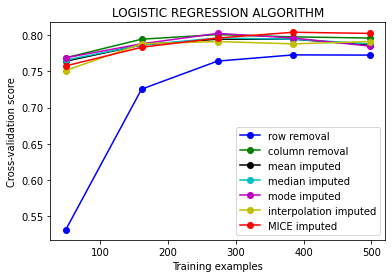

In [23]:
# list to be stored as tupled train, test features for plotting cross validation scores
features_training_list = []
# metrics modelling for row removal algorithm
print()
print("Metrics for row removal algorithm")
df_train = preprocess(df_row)
x_train, x_test, y_train, y_test = split_dataset(df_train)
y_pred = predict(x_train, x_test, y_train, y_test)
evaluate(y_pred, y_test)
features_training_list.append((x_train, y_train))
# metrics column removal
print()
print("Metrics for column removal algorithm")
df_train = preprocess(df_col)
x_train, x_test, y_train, y_test = split_dataset(df_train)
y_pred = predict(x_train, x_test, y_train, y_test)
evaluate(y_pred, y_test)
features_training_list.append((x_train, y_train))
# metrics mean imputation
print()
print("Metrics for mean imputation algorithm")
df_train = preprocess(df_stats_mean)
x_train, x_test, y_train, y_test = split_dataset(df_train)
y_pred = predict(x_train, x_test, y_train, y_test)
evaluate(y_pred, y_test)
features_training_list.append((x_train, y_train))
# metrics median imputation
print()
print("Metrics for median imputation algorithm")
df_train = preprocess(df_stats_median)
x_train, x_test, y_train, y_test = split_dataset(df_train)
y_pred = predict(x_train, x_test, y_train, y_test)
evaluate(y_pred, y_test)
features_training_list.append((x_train, y_train))
# metrics mode imputation
print()
print("Metrics for mode imputation algorithm")
df_train = preprocess(df_stats_mode)
x_train, x_test, y_train, y_test = split_dataset(df_train)
y_pred = predict(x_train, x_test, y_train, y_test)
evaluate(y_pred, y_test)
features_training_list.append((x_train, y_train))
# metrics interpolatation algorithm
print()
print("Metrics for interpolation imputation algorithm")
df_train = preprocess(df_interpolate)
x_train, x_test, y_train, y_test = split_dataset(df_train)
y_pred = predict(x_train, x_test, y_train, y_test)
evaluate(y_pred, y_test)
features_training_list.append((x_train, y_train))
# metrics MICE algorithm
print()
print("Metrics for MICE imputation algorithm")
df_train = preprocess(df_mice)
x_train, x_test, y_train, y_test = split_dataset(df_train)
y_pred = predict(x_train, x_test, y_train, y_test)
evaluate(y_pred, y_test)
features_training_list.append((x_train, y_train))

print("Maximum Accuracy and minimum loss is obtained from using MICE imputation algorithm !")
plot_metrics(features_training_list)

In [25]:
# saving the file and writing to output path provided
df_mice.to_csv(csv_data, index = False)
print()
print(f"DataFrame of shape {df_mice.shape} written to data/output.csv")


DataFrame of shape (891, 11) written to data/output.csv


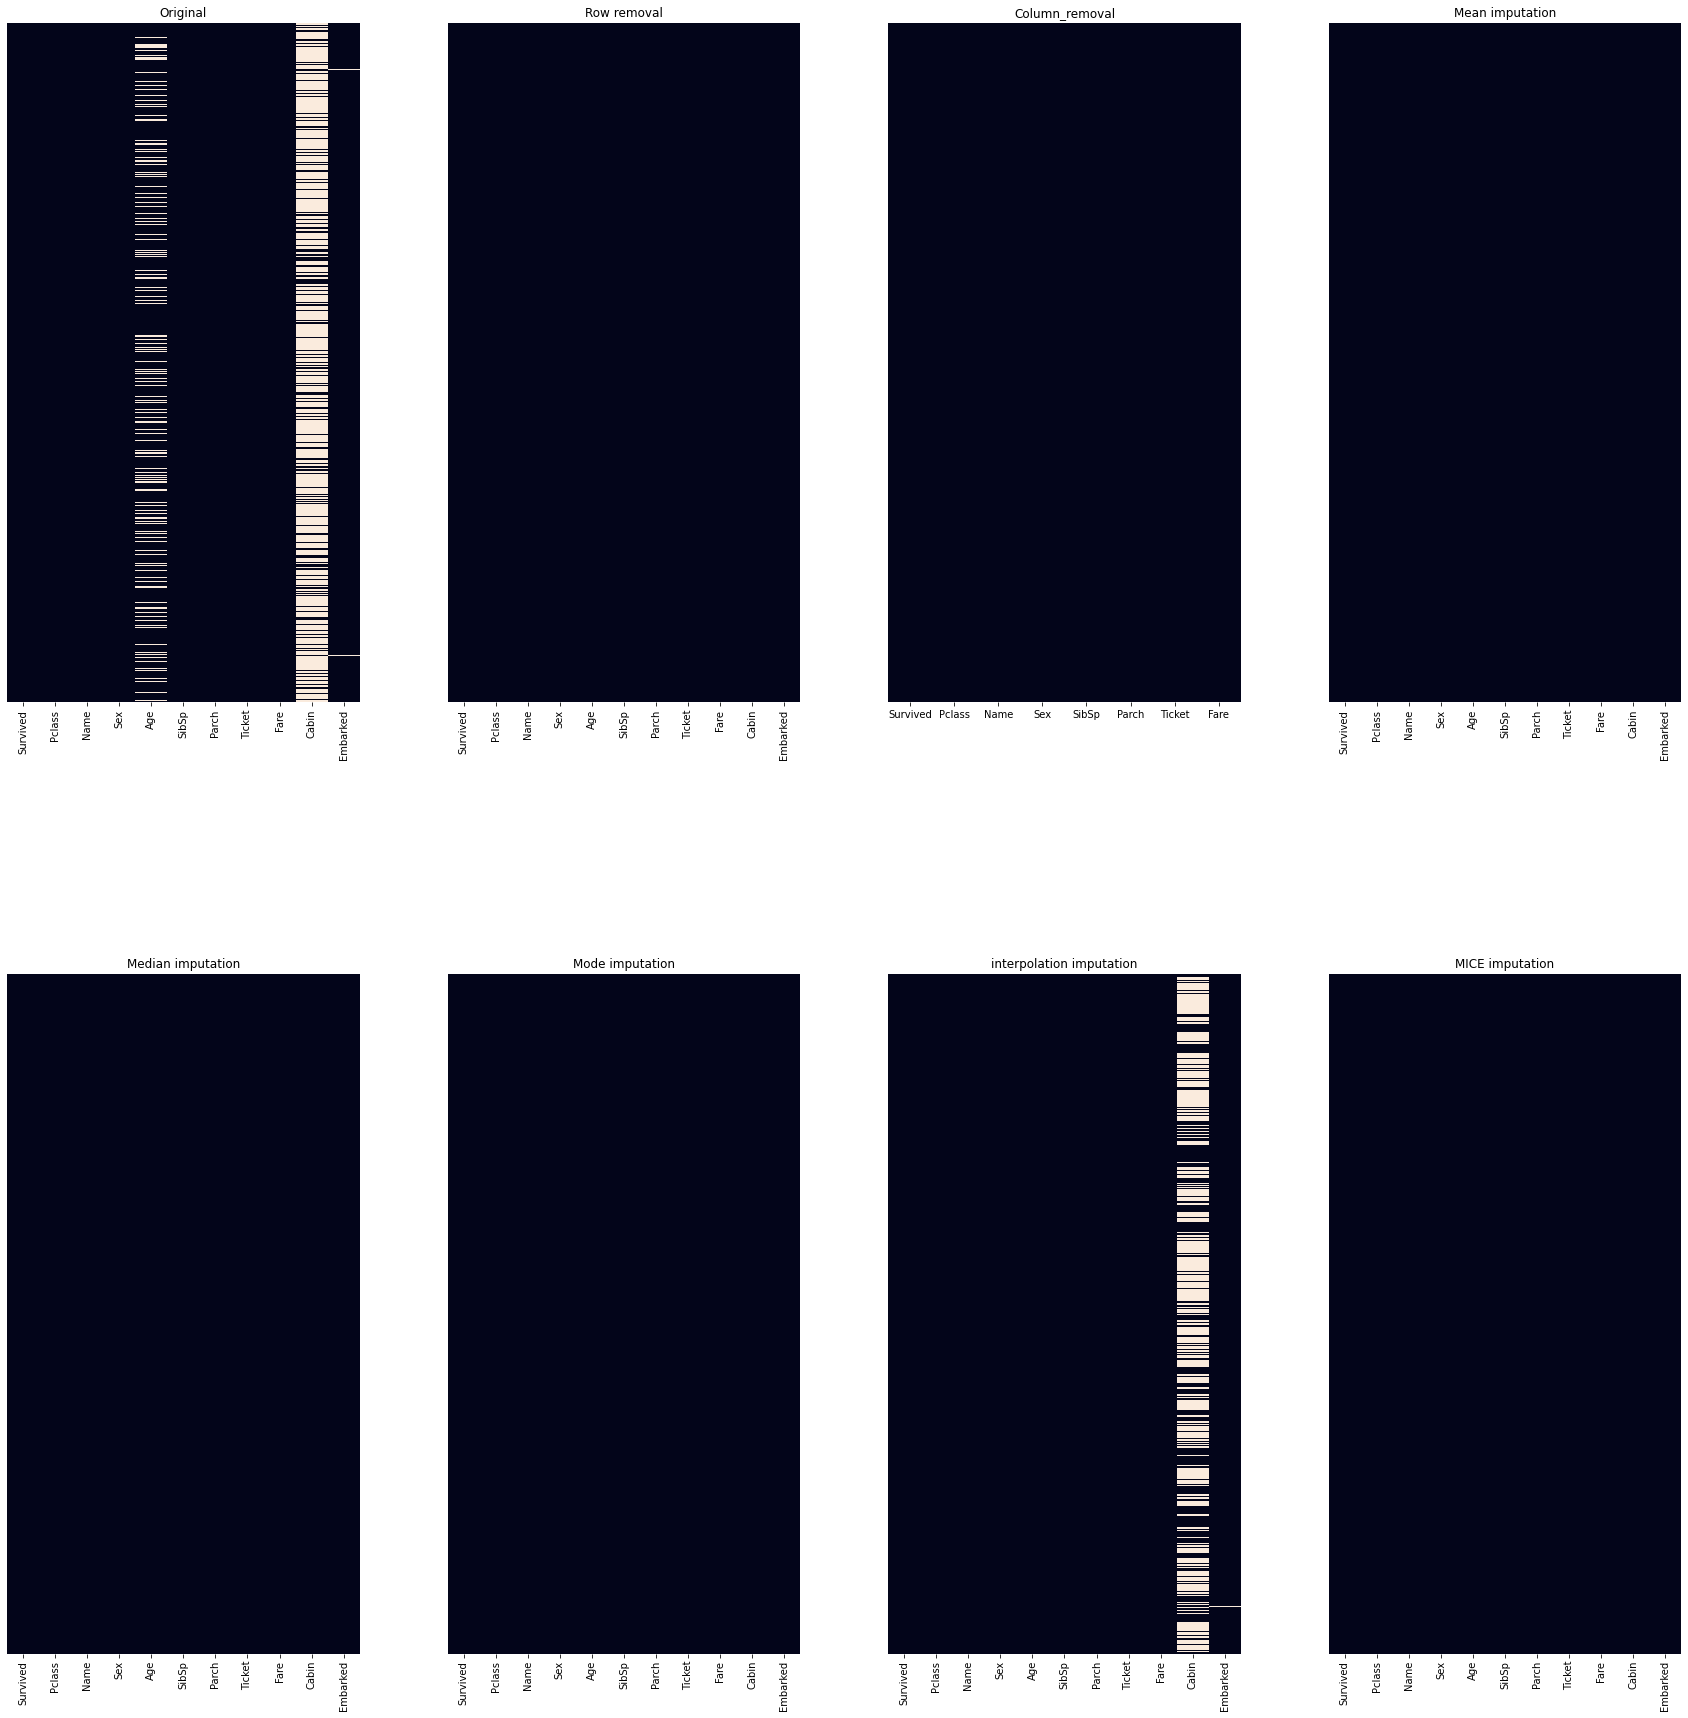

In [26]:
# useful when , you need to see the actual Statistics of missing values
# Plotting results for best missing values handling algorithm
# # plotting results
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(30,30))
plt.subplots_adjust(wspace=0.25, hspace=0.4)
sns.heatmap(dframe.isnull(), yticklabels=False, cbar=False, cmap='rocket', ax = axes[0][0]).set_title("Original")
sns.heatmap(df_row.isnull(), yticklabels=False, cbar=False, cmap='rocket', ax = axes[0][1]).set_title("Row removal")
sns.heatmap(df_col.isnull(), yticklabels=False, cbar=False, cmap='rocket', ax = axes[0][2]).set_title("Column_removal")
sns.heatmap(df_stats_mean.isnull(), yticklabels=False, cbar=False, cmap='rocket', ax = axes[0][3]).set_title("Mean imputation")
sns.heatmap(df_stats_median.isnull(), yticklabels=False, cbar=False, cmap='rocket', ax = axes[1][0]).set_title("Median imputation")
sns.heatmap(df_stats_mode.isnull(), yticklabels=False, cbar=False, cmap='rocket', ax = axes[1][1]).set_title("Mode imputation")
sns.heatmap(df_interpolate.isnull(), yticklabels=False, cbar=False, cmap='rocket', ax = axes[1][2]).set_title("interpolation imputation")
sns.heatmap(df_mice.isnull(), yticklabels=False, cbar=False, cmap='rocket', ax = axes[1][3]).set_title("MICE imputation")
plt.show()